In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
REBUILD_DATA = True
class DogsVSCats():
    IMG_SIZE = 50
    CATS = 'C:/Users/rrsoo/AdvancedStuff/PyTorch/CatsAndDogs/train/Cat'
    DOGS = 'C:/Users/rrsoo/AdvancedStuff/PyTorch/CatsAndDogs/train/Dog'
    LABELS = {CATS:0, DOGS:1}
    
    training_data = []
    
    catcount = 0
    dogcount = 0
    
    def make_training_data(self):
        for label in self.LABELS:
            for f in tqdm(os.listdir(label)):
                try:
                    path = os.path.join(label, f)
                    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                    self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]]) #np.eye creates one hot vectors

                    if label == self.CATS:
                        self.catcount+=1
                    elif label == self.DOGS:
                        self.dogcount+=1
                except Exception as e:
                    pass
                
        np.random.shuffle(self.training_data)
        np.save('training_data.npy', self.training_data)
        print('Cats:', self.catcount)
        print('Dogs:', self.dogcount)

        
if REBUILD_DATA:
    dogsvscats = DogsVSCats()
    dogsvscats.make_training_data()

100%|██████████| 12500/12500 [00:14<00:00, 844.42it/s]


Cats: 12500
Dogs: 12500


In [3]:
training_data = np.load('training_data.npy', allow_pickle = True)

[0. 1.]


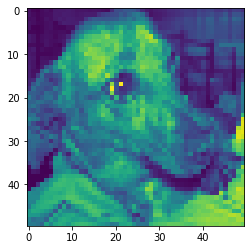

In [4]:
plt.imshow(training_data[0][0])
print(training_data[0][1])

In [5]:
class NN(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 20, 3)
        self.conv2 = nn.Conv2d(20, 50, 5)
        
        self.fc1 = nn.Linear(10*10*50, 500)
        self.fc2 = nn.Linear(500, 2)
        
    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2)
        X = X.view(-1, 10*10*50)
        X = F.relu(self.fc1(X))
        X = self.fc2(X)
        
        return F.softmax(X, dim = 1)

device = torch.device("cuda:0")
net = NN().to(device)
        

In [6]:
X = torch.Tensor([i[0] for i in training_data]).view(-1, 50, 50)
X = X/255.0
y = torch.Tensor([i[1] for i in training_data])

VAL_PCT = 0.1
val_size = int(len(X)*VAL_PCT)

X_train = X[:-val_size]
y_train = y[:-val_size]

X_test = X[-val_size:]
y_test = y[-val_size:]

In [7]:
BATCH_SIZE = 32
EPOCHS = 4

def train(net):
    opt = optim.Adam(net.parameters(), lr = 1e-3)
    loss_function = nn.MSELoss()

    for epoch in range(EPOCHS):
        for i in tqdm(range(0, len(X_train), BATCH_SIZE)):
            batch_X = X_train[i:i+BATCH_SIZE].view(-1, 1, 50, 50).to(device)
            batch_y = y_train[i:i+BATCH_SIZE].to(device)

            net.zero_grad()
            outputs = net(batch_X)
            loss = loss_function(outputs, batch_y)
            loss.backward()
            opt.step()
        print(loss)

In [8]:
train(net)

  2%|▏         | 12/704 [00:00<00:06, 112.45it/s]

tensor(0.2617, device='cuda:0', grad_fn=<MseLossBackward>)


  2%|▏         | 12/704 [00:00<00:06, 112.41it/s]

tensor(0.0877, device='cuda:0', grad_fn=<MseLossBackward>)


  2%|▏         | 12/704 [00:00<00:06, 111.37it/s]

tensor(0.0201, device='cuda:0', grad_fn=<MseLossBackward>)


100%|██████████| 704/704 [00:06<00:00, 107.72it/s]

tensor(0.0060, device='cuda:0', grad_fn=<MseLossBackward>)


In [9]:
def test(net):
    correct = 0
    total = 0
    with torch.no_grad():
        for i in tqdm(range(len(X_test))):
            actual = torch.argmax(y_test[i]).to(device)
            net_out = net(X_test[i].view(-1, 1, 50, 50).to(device))[0]
            preds = torch.argmax(net_out)
            if actual == preds:
                correct+=1
            total+=1

    print('Accuracy: ', correct/total)

In [10]:
test(net)

100%|██████████| 2500/2500 [00:03<00:00, 811.49it/s]

Accuracy:  0.7608


Cat


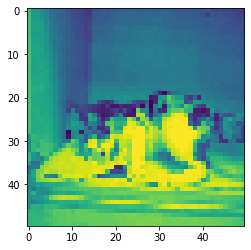

In [24]:
def prediction(n):
    plt.imshow(X_test[n])
    out = net(X_test[n].view(-1, 1, 50, 50).to(device))
    out = torch.round(out)
    if torch.eq(torch.argmax(out), torch.argmax(torch.Tensor([0,1]).to(device))):
        print("Dog")
    else:
        print("Cat")

prediction(3) #Remember: [0, 1] was assigned to Dog and [1, 0] was Cat

In [12]:
#Cuda activated variables can only interact with other cuda activated variables; we made our NN object cuda activated
#so other variables that need to interact with it need to have the .to(device)